In [17]:
from music21 import converter, note, chord, key, meter, instrument
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 1. Feature Extraction from MIDI Files

Here each MIDI file in the dataset is parsed to extract symbolic musical features such as pitch, duration, polyphony, key signature, and instrument information. These are compiled into a structured DataFrame for further analysis.

In [2]:
def get_midi_features(midi_file, instrument_family_map):
    try:
        # Parse the MIDI file into a music21 stream object
        score = converter.parse(midi_file)

        # Flatten the stream to simplify traversal (all elements at the same level)
        flat = score.flatten()

        # Analyze the global key signature of the piece
        key_signature = flat.analyze('key')
        # Encode key as integer 0–11 for tonic pitch class + 12 if minor mode to distinguish modality
        key_index = key_signature.tonic.pitchClass + (12 if key_signature.mode == 'minor' else 0)

        # Get the first time signature encountered in the score, default to 4/4 if missing
        time_signature = flat.recurse().getElementsByClass(meter.TimeSignature).first()
        time_sig = str(time_signature.ratioString) if time_signature else '4/4'

        features = []  # List to hold feature dictionaries for each musical event
        previous_pitch = None  # To compute interval to previous note

        # Group notes and chords by their onset time to detect polyphony (simultaneous notes)
        offset_dict = {}
        for element in flat.notes:
            offset_dict.setdefault(element.offset, []).append(element)

        # Define helper function to extract instrument name and family from context
        def extract_instrument(element):
            instr_name = "Unknown"
            instr_family = "Other"
            instr = element.getContextByClass(instrument.Instrument)
            if instr and hasattr(instr, 'midiProgram'):
                try:
                    # Attempt to recover instrument name from MIDI program
                    instr_obj = instrument.instrumentFromMidiProgram(instr.midiProgram)
                    instr_name = instr_obj.instrumentName
                    # Use family mapping if provided
                    instr_family = instrument_family_map.get(instr_name, "Other") if instrument_family_map else "Other"
                except Exception:
                    pass  # Fallback to defaults if resolution fails
            return instr_name, instr_family

        # Iterate over each onset time and the notes/chords sounding at that time
        for offset, simultaneous_notes in offset_dict.items():
            polyphony = len(simultaneous_notes)  # Number of overlapping events at this onset

            for element in simultaneous_notes:
                # Extract instrument information from the context of the element
                instr_name, instr_family = extract_instrument(element)

                if isinstance(element, note.Note):
                    # Extract basic pitch and timing features
                    pitch = element.pitch.midi  # MIDI pitch number (0–127)
                    pitch_class = element.pitch.pitchClass  # Pitch class modulo 12
                    duration = element.quarterLength  # Note duration in quarter lengths

                    # Calculate melodic interval to previous note; 0 if this is the first note
                    interval_to_prev = abs(pitch - previous_pitch) if previous_pitch is not None else 0
                    previous_pitch = pitch  # Update for next comparison

                    # Structural location of the event in the score
                    measure_number = element.measureNumber if element.measureNumber is not None else 0

                    # Whether the note is part of a chord (set to 0 here; see chord block for 1)
                    is_chord_tone = 0

                    # Append the extracted features for this note event
                    features.append({
                        'pitch': pitch,
                        'pitch_class': pitch_class,
                        'onset': offset,
                        'duration': duration,
                        'interval_to_prev': interval_to_prev,
                        'polyphony': polyphony,
                        'is_chord_tone': is_chord_tone,
                        'key': key_index,
                        'time_signature': time_sig,
                        'measure': measure_number,
                        'instrument': instr_name,
                        'instrument_family': instr_family
                    })

                elif isinstance(element, chord.Chord):
                    # Extract pitch and duration for each note in the chord
                    duration = element.quarterLength
                    measure_number = element.measureNumber if element.measureNumber is not None else 0
                    is_chord_tone = 1  # Chord members are marked as chord tones

                    for pitch in [p.midi for p in element.pitches]:
                        pitch_class = pitch % 12
                        interval_to_prev = abs(pitch - previous_pitch) if previous_pitch is not None else 0
                        previous_pitch = pitch

                        # Append feature dict for each note in the chord separately
                        features.append({
                            'pitch': pitch,
                            'pitch_class': pitch_class,
                            'onset': offset,
                            'duration': duration,
                            'interval_to_prev': interval_to_prev,
                            'polyphony': polyphony,
                            'is_chord_tone': is_chord_tone,
                            'key': key_index,
                            'time_signature': time_sig,
                            'measure': measure_number,
                            'instrument': instr_name,
                            'instrument_family': instr_family
                        })

        return features

    except Exception as e:
        # Catch and report any parsing or extraction errors gracefully
        print(f"[ERROR] Could not parse {midi_file}: {e}")
        return []

In [3]:
# Add instrument family to each event for higher-level grouping (e.g., strings, winds, percussion)
# This enables downstream analysis of timbral or orchestration patterns across genres or pieces

instrument_family_map = {
    # Keyboard
    'Piano': 'Keyboard',
    'Celesta': 'Keyboard',
    'Electric Organ': 'Keyboard',
    'Organ': 'Keyboard',
    'Harpsichord': 'Keyboard',

    # Guitar
    'Acoustic Guitar': 'Guitar',
    'Electric Guitar': 'Guitar',

    # Bass
    'Acoustic Bass': 'Bass',
    'Electric Bass': 'Bass',
    'Fretless Bass': 'Bass',
    'Contrabass': 'Bass',

    # Strings
    'Violoncello': 'Strings',
    'Violin': 'Strings',
    'Viola': 'Strings',
    'Double Bass': 'Strings',
    'StringInstrument': 'Strings',

    # Brass
    'Trumpet': 'Brass',
    'Trombone': 'Brass',
    'French Horn': 'Brass',
    'Tuba': 'Brass',

    # Woodwind
    'Clarinet': 'Woodwind',
    'Bassoon': 'Woodwind',
    'Recorder': 'Woodwind',
    'Piccolo': 'Woodwind',
    'Flute': 'Woodwind',
    'Whistle': 'Woodwind',

    # Percussion
    'Timpani': 'Percussion',
    'Taiko': 'Percussion',
    'Marimba': 'Percussion',
    'Glockenspiel': 'Percussion',
    'Drums': 'Percussion',

    # Voice
    'Voice': 'Voice',
    'Choir': 'Voice',
    'Vocals': 'Voice',
    'Background Vocals': 'Voice',

    # Electronic
    'Sampler': 'Electronic',
    'Synthesizer': 'Electronic',
    'Electric Piano': 'Electronic',
    'Electric Organ': 'Electronic',

    # Other / Catch-all
    'Bagpipes': 'Other',
    'Ocarina': 'Other',
    'Unknown': 'Other',
}

In [4]:
# Define the path to the root folder containing genre-labeled subfolders of MIDI files
root_path = 'data'

# Initialize an empty list to collect feature dictionaries across all files and genres
all_features = []

# Traverse each genre subfolder in the dataset
for genre in os.listdir(root_path):
    genre_path = os.path.join(root_path, genre)
    
    # Skip non-directory files (e.g., stray files in the root directory)
    if not os.path.isdir(genre_path):
        continue

    # Process each MIDI file within the current genre folder
    for file in os.listdir(genre_path):
        if not file.lower().endswith('.mid'):
            continue  # Ignore non-MIDI files

        file_path = os.path.join(genre_path, file)

        # Extract symbolic musical features from the current MIDI file
        features = get_midi_features(file_path, instrument_family_map)

        # Append genre label and filename metadata to each feature row
        for feature in features:
            feature['genre'] = genre
            feature['filename'] = file
            all_features.append(feature)

# Aggregate all extracted features into a structured pandas DataFrame
df = pd.DataFrame(all_features)

# Display the first few rows for inspection
df.head()

,pitch,pitch_class,onset,duration,interval_to_prev,polyphony,is_chord_tone,key,time_signature,measure,instrument,instrument_family,genre,filename
0,27,3,4.0,0.75,0,4,0,3,4/4,2,Sampler,Electronic,pop,Come On Over (All I Want Is You).mid
1,39,3,4.0,0.75,12,4,0,3,4/4,2,Sampler,Electronic,pop,Come On Over (All I Want Is You).mid
2,27,3,4.0,0.75,12,4,0,3,4/4,2,Sampler,Electronic,pop,Come On Over (All I Want Is You).mid
3,39,3,4.0,0.75,12,4,0,3,4/4,2,Sampler,Electronic,pop,Come On Over (All I Want Is You).mid
4,79,7,5.0,0.5,40,2,0,3,4/4,2,Sampler,Electronic,pop,Come On Over (All I Want Is You).mid


---

## 2. Data Quality Assessment

Here a preliminary audit of the extracted MIDI features is performed to ensure structural integrity, identify potential anomalies, and confirm the plausibility of musical attributes such as pitch, duration, key, and instrumentation.

### 2.1 Missing Data Analysis

In [25]:
# Check for missing values
df.isnull().sum()

pitch                0
pitch_class          0
onset                0
duration             0
interval_to_prev     0
polyphony            0
is_chord_tone        0
key                  0
time_signature       0
measure              0
instrument           0
instrument_family    0
genre                0
filename             0
dtype: int64

### 2.2 Summary Statistics

In [26]:
# Summary statistics for numerical columns
df.describe()

,pitch,pitch_class,interval_to_prev,polyphony,is_chord_tone,key,measure
count,192192.000000,192192.000000,192192.000000,192192.000000,192192.000000,192192.000000,192192.000000
mean,58.926469,5.541729,11.667582,3.983355,0.654731,10.325523,77.063489
std,13.160204,3.433102,11.094037,2.403797,0.475457,6.610722,57.363941
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,52.000000,3.000000,4.000000,2.000000,0.000000,5.000000,35.000000
50%,61.000000,6.000000,7.000000,4.000000,1.000000,11.000000,65.000000
75%,67.000000,9.000000,17.000000,5.000000,1.000000,16.000000,104.000000
max,126.000000,11.000000,93.000000,17.000000,1.000000,23.000000,393.000000


### 2.3 Feature-wise Distribution and Outlier Analysis

#### 2.3.1 Pitch

##### 2.3.1.1 Central Tendency and Spread of Pitch Values

In [42]:
# Central tendency
mean_pitch = df['pitch'].mean()
median_pitch = df['pitch'].median()
mode_pitch = df['pitch'].mode()[0]  # mode() returns a Series

# Spread
std_pitch = df['pitch'].std()

# Display results
print(f"Mean pitch: {mean_pitch:.2f}")
print(f"Median pitch: {median_pitch}")
print(f"Mode pitch: {mode_pitch}")
print(f"Standard deviation: {std_pitch:.2f}")

Mean pitch: 58.93
Median pitch: 61.0
Mode pitch: 67
Standard deviation: 13.16


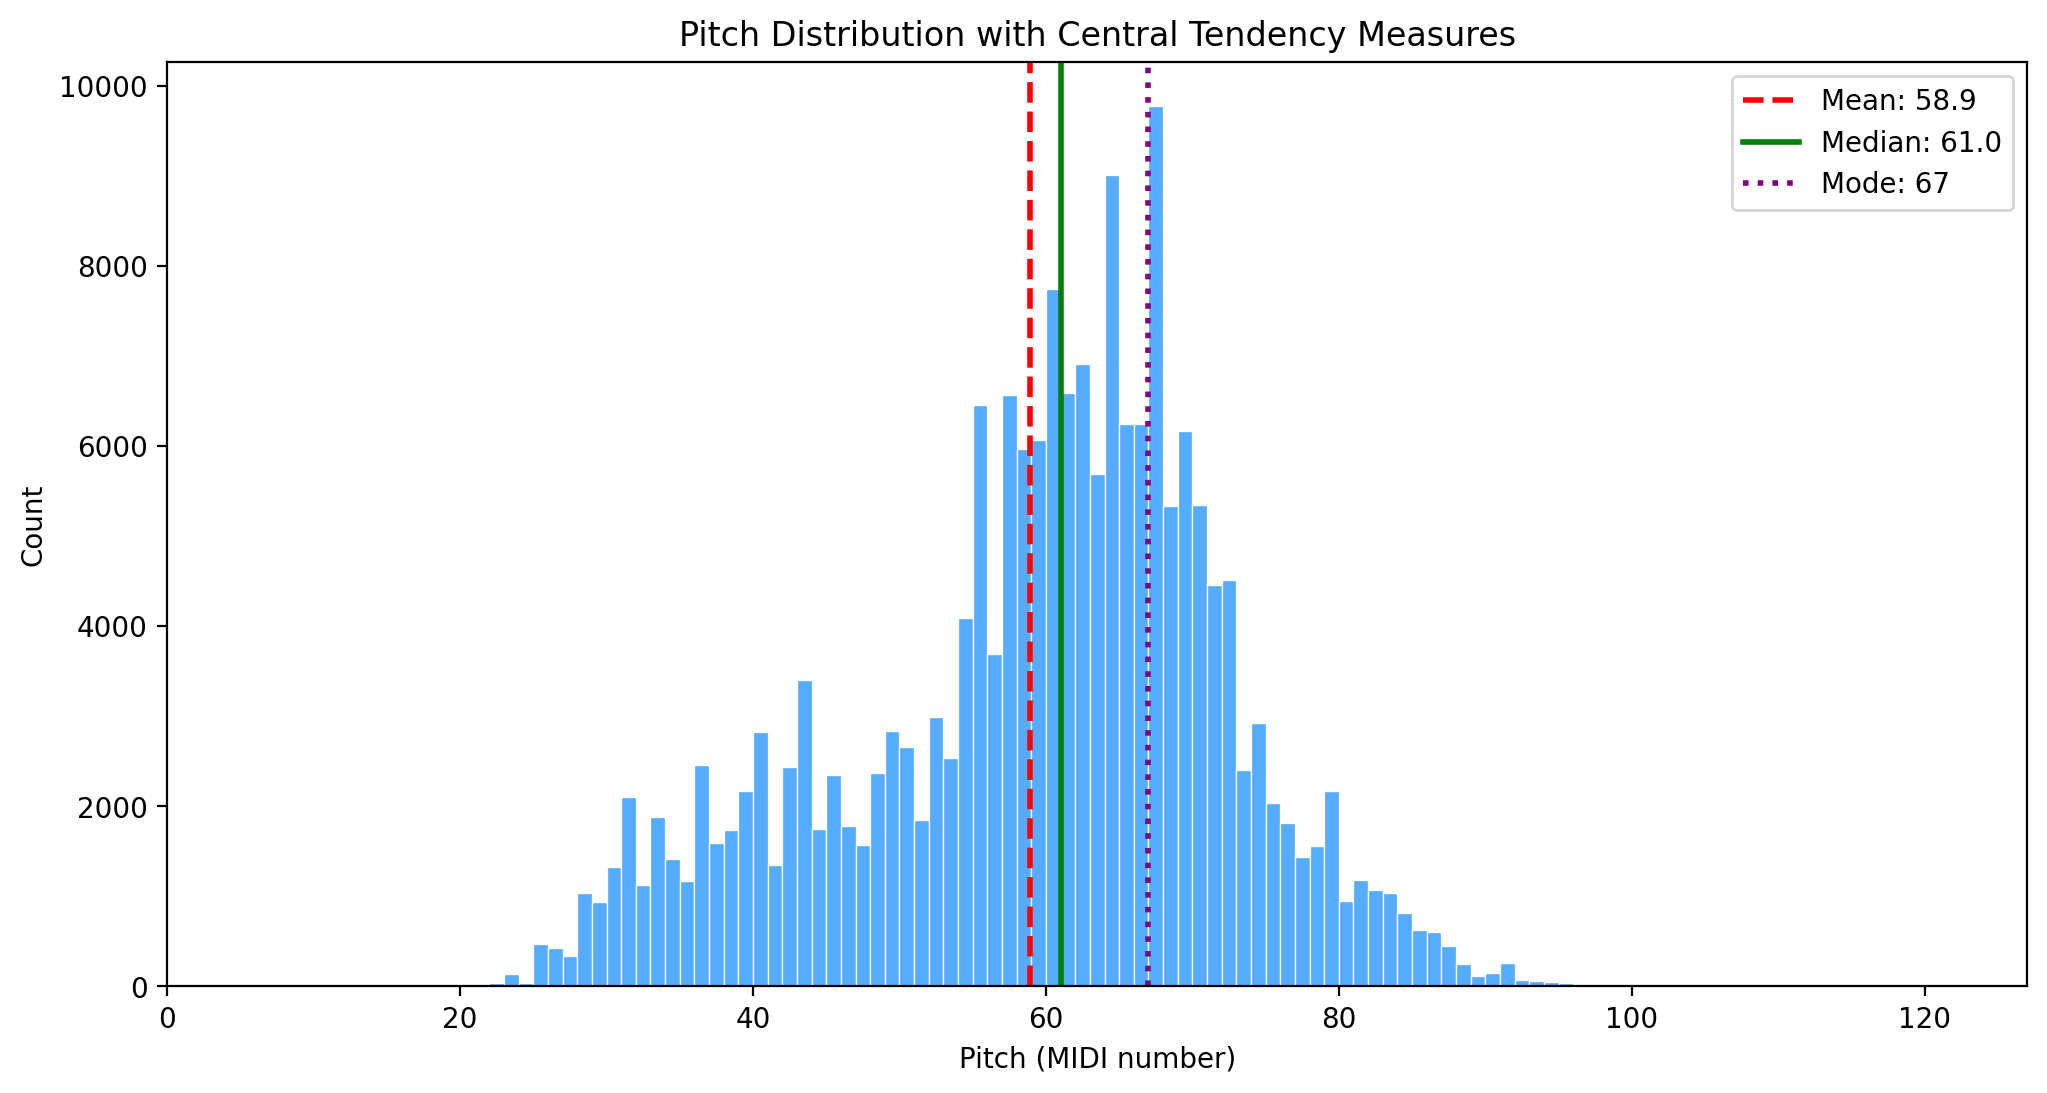

In [43]:
plt.figure(figsize=(12, 6))
sns.histplot(df['pitch'], bins=range(0, 128), color='dodgerblue', edgecolor='white')

# Add lines for mean, median, and mode
plt.axvline(mean_pitch, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_pitch:.1f}')
plt.axvline(median_pitch, color='green', linestyle='-', linewidth=2, label=f'Median: {median_pitch}')
plt.axvline(mode_pitch, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode_pitch}')

plt.title('Pitch Distribution with Central Tendency Measures')
plt.xlabel('Pitch (MIDI number)')
plt.ylabel('Count')
plt.xlim(0, 127)
plt.legend()
plt.show()

##### 2.3.1.2 Extreme Values

In [44]:
# Confirm all values are within the valid MIDI range
valid_range = df['pitch'].between(0, 127)
invalid_pitches = df[~valid_range]

print(f"Number of invalid pitch values: {len(invalid_pitches)}")

# Investigate extreme values
extreme_pitches = df[df['pitch'].isin([0, 126, 127])]
print(f"\nNumber of extreme pitch values (0, 126, 127): {len(extreme_pitches)}")
print(extreme_pitches['pitch'].value_counts().sort_index())

Number of invalid pitch values: 0

Number of extreme pitch values (0, 126, 127): 2
pitch
0      1
126    1
Name: count, dtype: int64


##### 2.3.1.3 Outlier Detection in Pitch Values

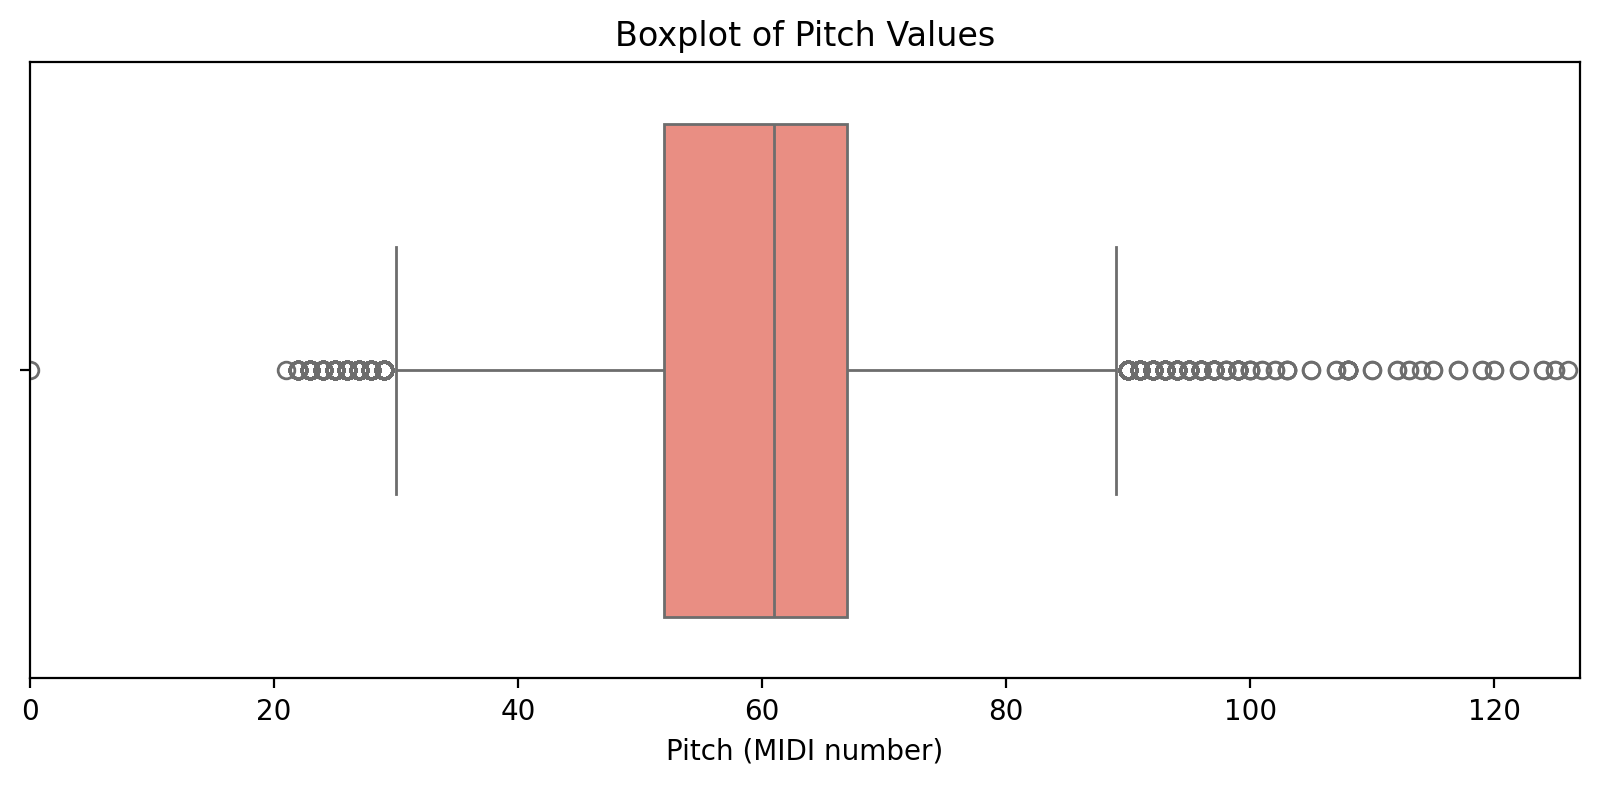

In [51]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['pitch'], color='salmon')
plt.title('Boxplot of Pitch Values')
plt.xlabel('Pitch (MIDI number)')
plt.xlim(0, 127)
plt.show()

In [46]:
# Count how many values are at the extreme edges
low_extremes = df[df['pitch'] <= 10]
high_extremes = df[df['pitch'] >= 120]

print(f"Pitches ≤ 10: {len(low_extremes)}")
print(f"Pitches ≥ 120: {len(high_extremes)}")

Pitches ≤ 10: 1
Pitches ≥ 120: 9


##### 2.3.1.4 Distribution of Pitch Values over Time

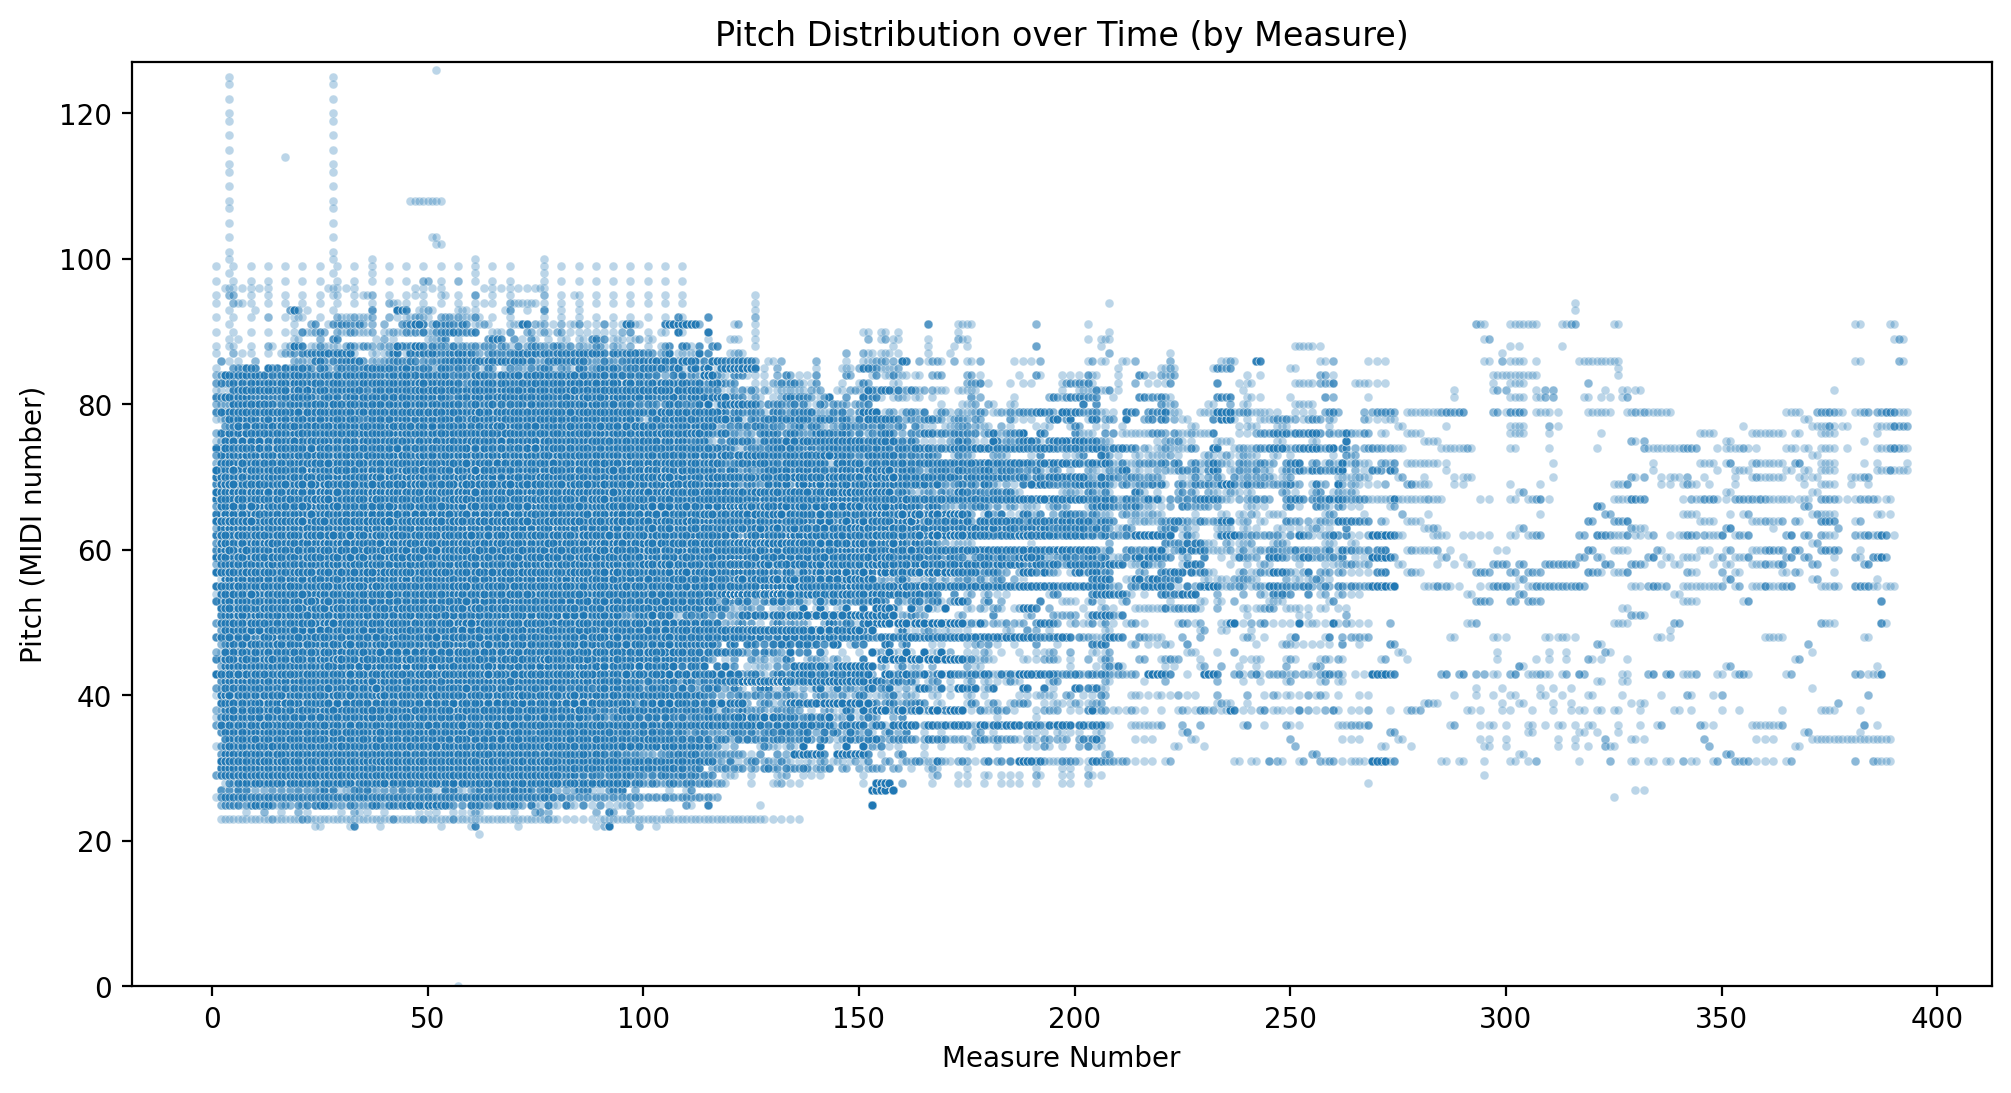

In [48]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='measure', y='pitch', alpha=0.3, s=10)
plt.title('Pitch Distribution over Time (by Measure)')
plt.xlabel('Measure Number')
plt.ylabel('Pitch (MIDI number)')
plt.ylim(0, 127)
plt.show()

##### 2.3.1.5 Pitch Values in Context: Key, Instrument, and Genre

In [63]:
# --- Descriptive statistics pitch by key ---
print("\nPitch statistics by Key:")
df.groupby('key')['pitch'].describe().sort_index()


Pitch statistics by Key:


,count,mean,std,min,25%,50%,75%,max
key,,,,,,,,
0,11608.0,60.164197,12.061647,26.0,55.0,62.0,67.0,94.0
1,8535.0,59.241593,12.281938,25.0,54.0,61.0,68.0,85.0
2,5075.0,51.538128,12.461904,28.0,42.0,52.0,62.0,80.0
3,13501.0,57.650174,13.575170,22.0,45.0,60.0,68.0,89.0
4,8834.0,61.718021,12.814249,25.0,59.0,64.0,68.0,103.0
5,17733.0,59.695370,13.625962,24.0,54.0,63.0,70.0,96.0
6,4806.0,60.663337,11.850484,25.0,56.0,61.0,68.0,85.0
7,10897.0,63.209966,12.839228,31.0,55.0,64.0,74.0,88.0
9,3344.0,54.743122,15.504270,28.0,45.0,52.0,62.0,93.0


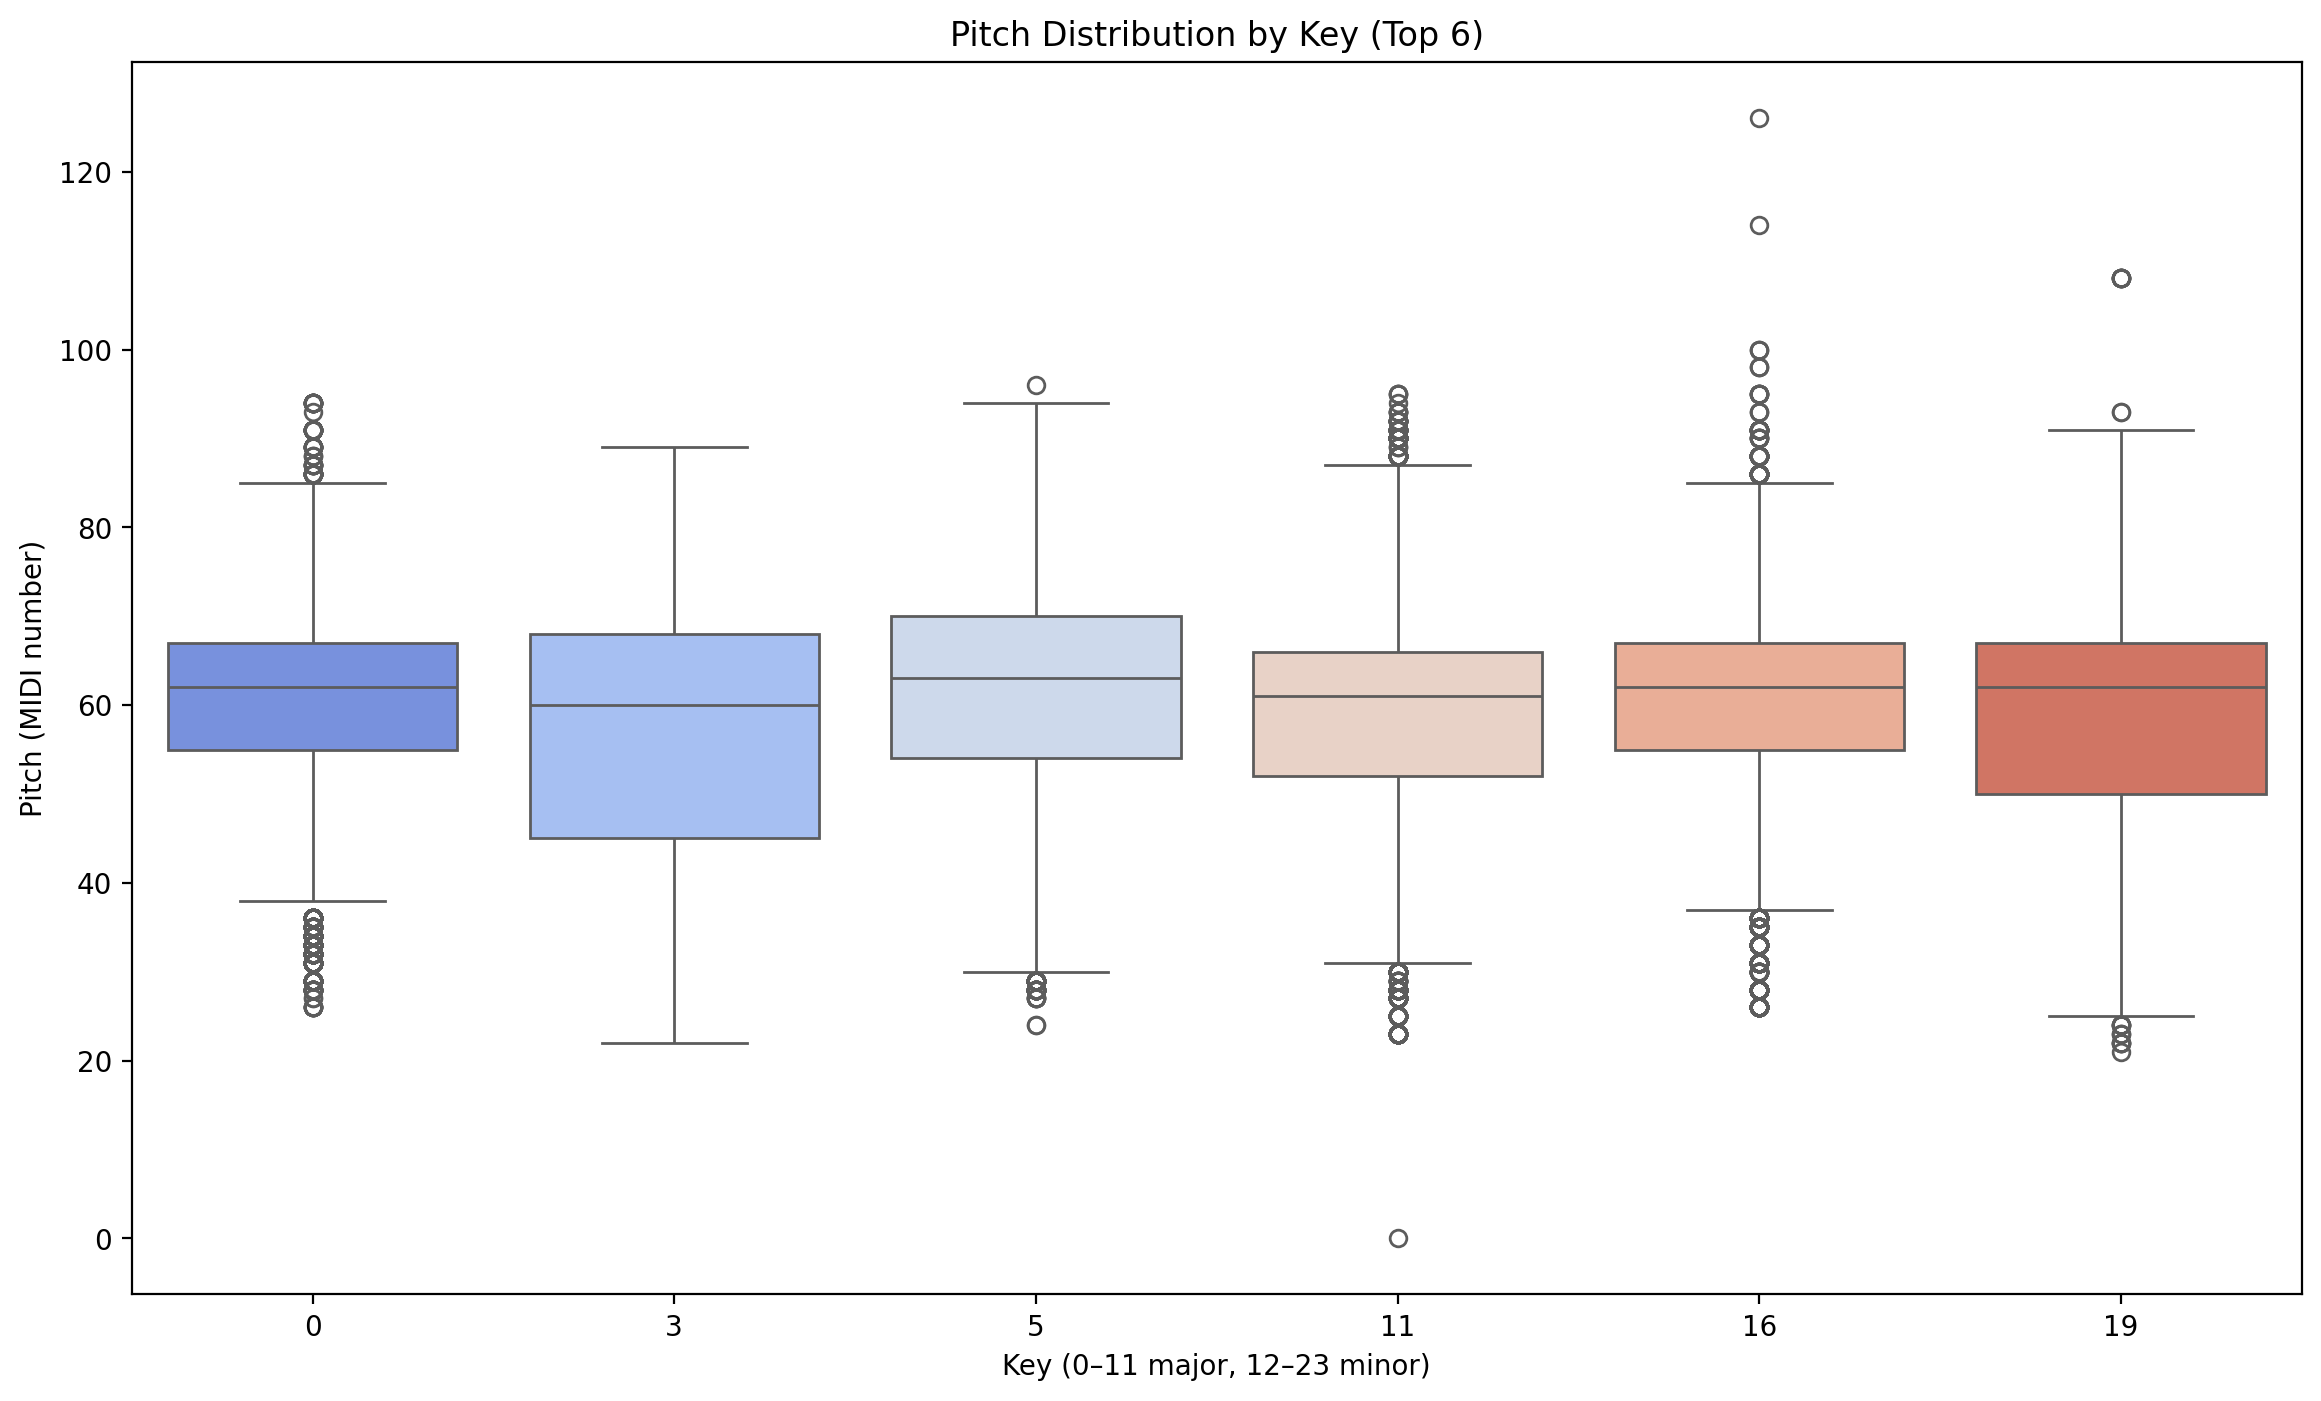

In [53]:
top_keys = df['key'].value_counts().nlargest(6).index

plt.figure(figsize=(14, 8))
sns.boxplot(data=df[df['key'].isin(top_keys)], x='key', y='pitch', palette='coolwarm')
plt.title('Pitch Distribution by Key (Top 6)')
plt.xlabel('Key (0–11 major, 12–23 minor)')
plt.ylabel('Pitch (MIDI number)')
plt.show()

In [61]:
# --- Descriptive statistics pitch by instrument ---
print("\nPitch statistics by Instrument:")
df.groupby('instrument')['pitch'].describe()


Pitch statistics by Instrument:


,count,mean,std,min,25%,50%,75%,max
instrument,,,,,,,,
Acoustic Bass,11262.0,58.854644,11.072530,25.0,54.0,61.0,66.0,85.0
Acoustic Guitar,18001.0,57.747292,11.193404,23.0,49.0,59.0,66.0,95.0
Bagpipes,4865.0,61.319219,13.356028,25.0,56.0,65.0,70.0,85.0
Bassoon,1729.0,62.702718,12.618631,31.0,50.0,67.0,72.0,83.0
Celesta,8514.0,58.845431,13.070046,26.0,55.0,60.0,67.0,126.0
Choir,2984.0,54.846180,13.325125,29.0,44.0,58.0,66.0,85.0
Clarinet,998.0,59.876754,15.863189,25.0,49.0,68.0,68.0,103.0
Contrabass,9168.0,63.305628,12.878847,31.0,55.0,64.0,74.0,88.0
Electric Bass,647.0,57.649150,10.621358,30.0,49.0,61.0,66.0,78.0


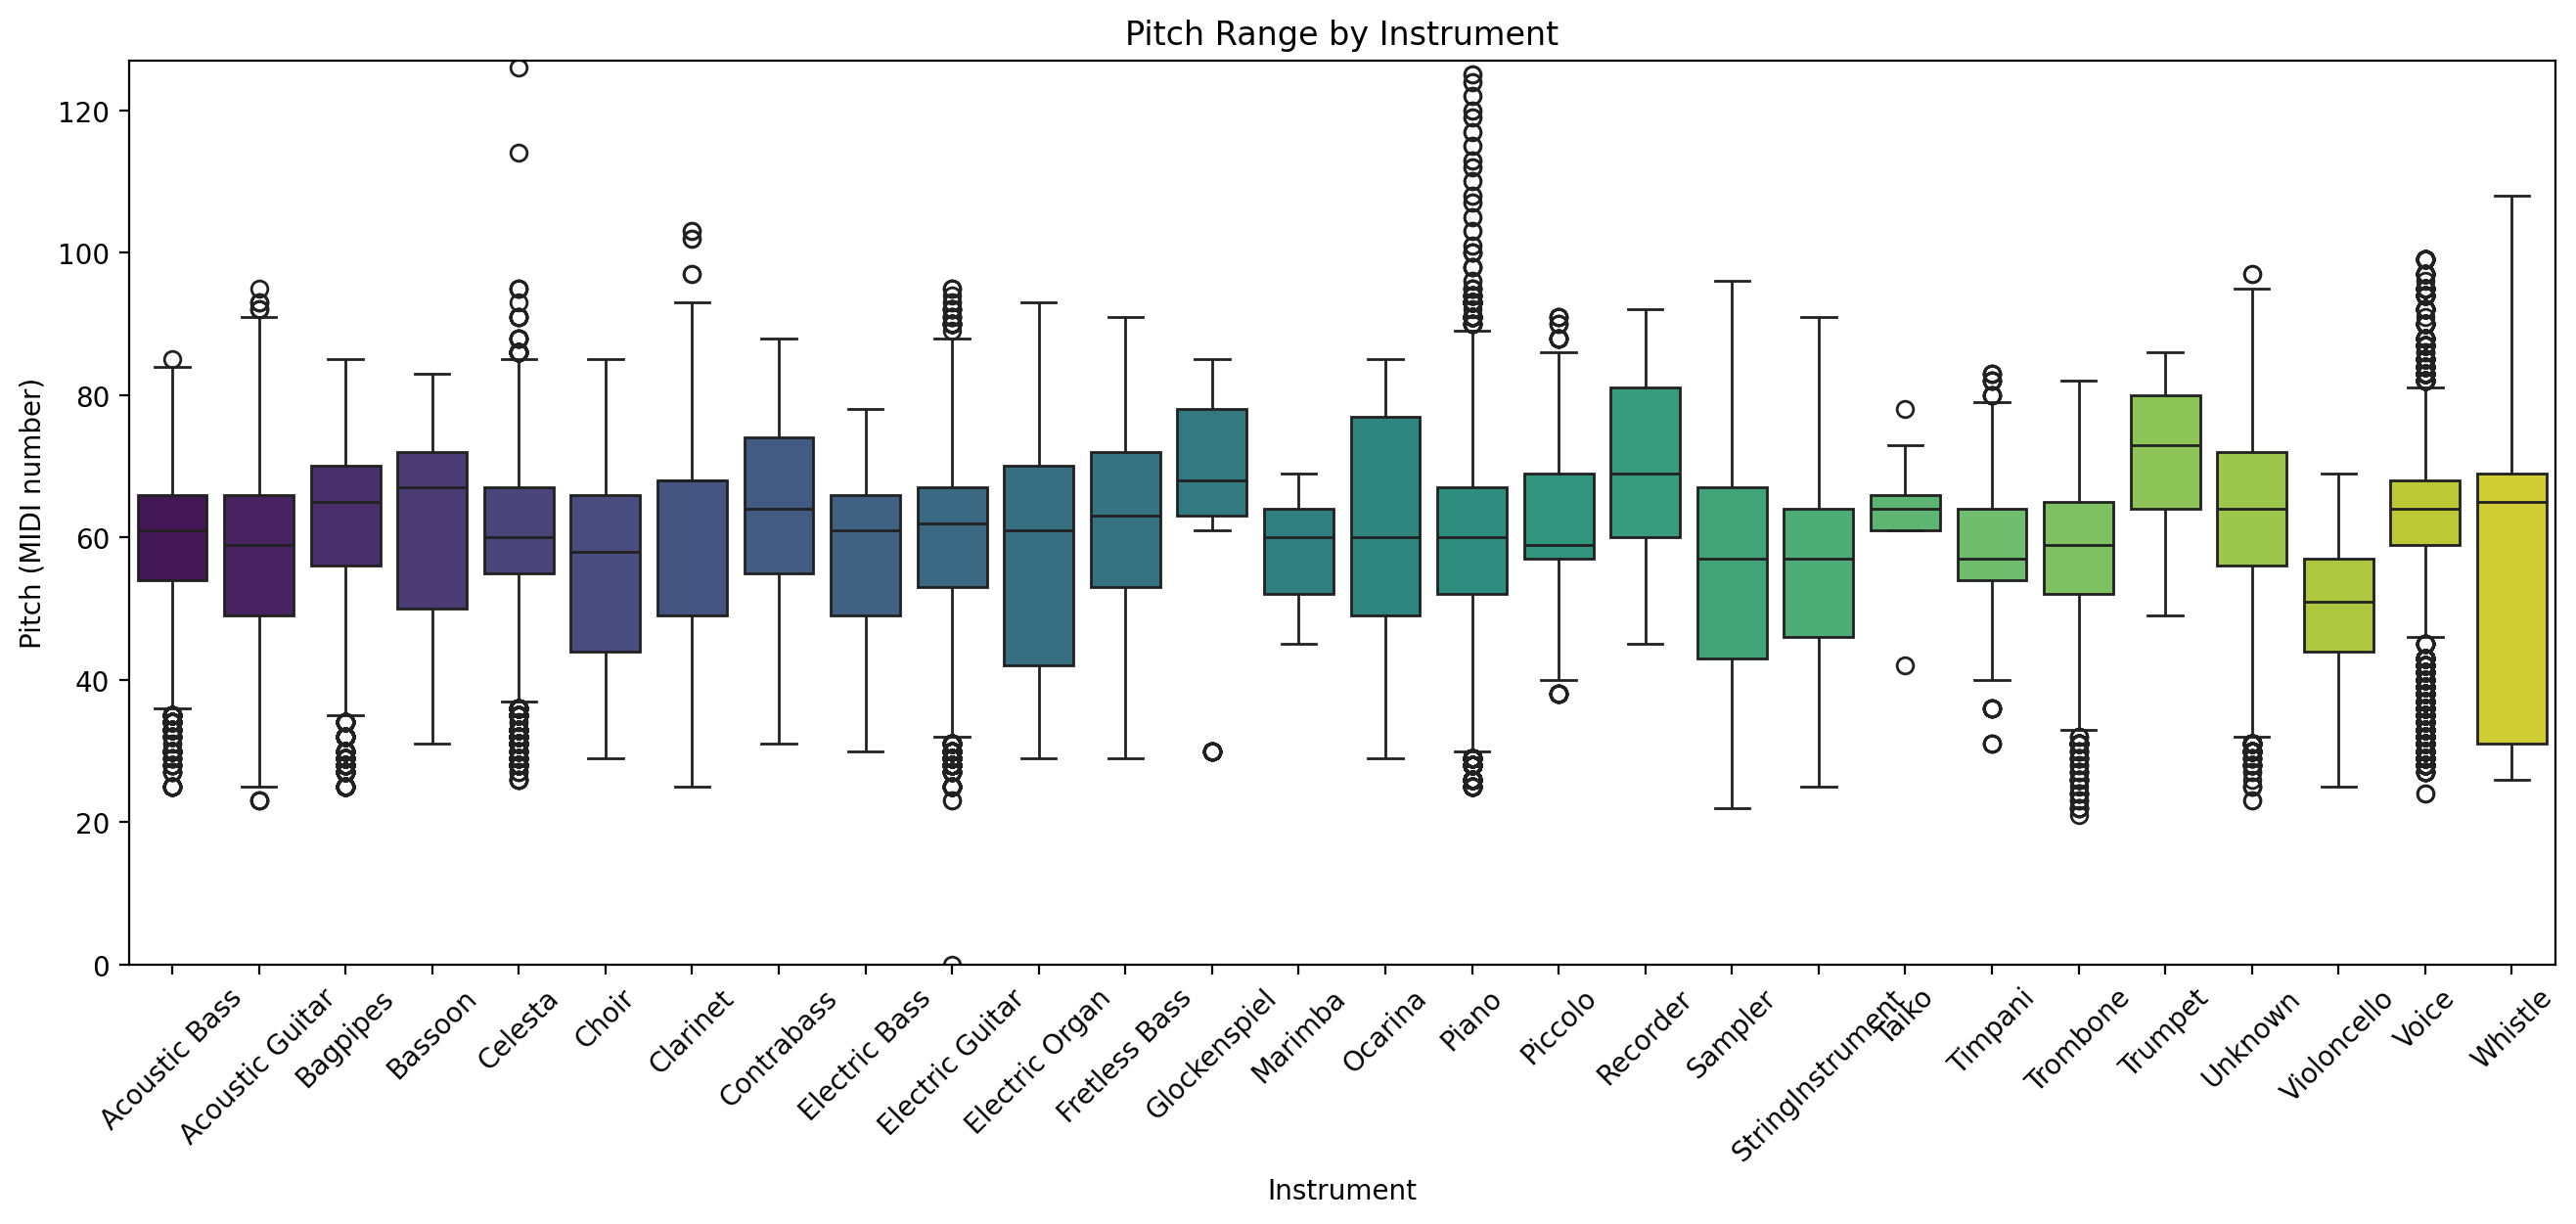

In [68]:
alphabetic_order = sorted(df['instrument'].unique())

plt.figure(figsize=(16, 6))
sns.boxplot(data=df, x='instrument', y='pitch', palette='viridis', order=alphabetic_order)
plt.xticks(rotation=45)
plt.title('Pitch Range by Instrument')
plt.xlabel('Instrument')
plt.ylabel('Pitch (MIDI number)')
plt.ylim(0, 127)
plt.show()

In [62]:
# --- Descriptive statistics pitch by instrument family ---
print("\nPitch statistics by Instrument Family:")
df.groupby('instrument')['pitch'].describe()


Pitch statistics by Instrument Family:


,count,mean,std,min,25%,50%,75%,max
instrument,,,,,,,,
Acoustic Bass,11262.0,58.854644,11.072530,25.0,54.0,61.0,66.0,85.0
Acoustic Guitar,18001.0,57.747292,11.193404,23.0,49.0,59.0,66.0,95.0
Bagpipes,4865.0,61.319219,13.356028,25.0,56.0,65.0,70.0,85.0
Bassoon,1729.0,62.702718,12.618631,31.0,50.0,67.0,72.0,83.0
Celesta,8514.0,58.845431,13.070046,26.0,55.0,60.0,67.0,126.0
Choir,2984.0,54.846180,13.325125,29.0,44.0,58.0,66.0,85.0
Clarinet,998.0,59.876754,15.863189,25.0,49.0,68.0,68.0,103.0
Contrabass,9168.0,63.305628,12.878847,31.0,55.0,64.0,74.0,88.0
Electric Bass,647.0,57.649150,10.621358,30.0,49.0,61.0,66.0,78.0


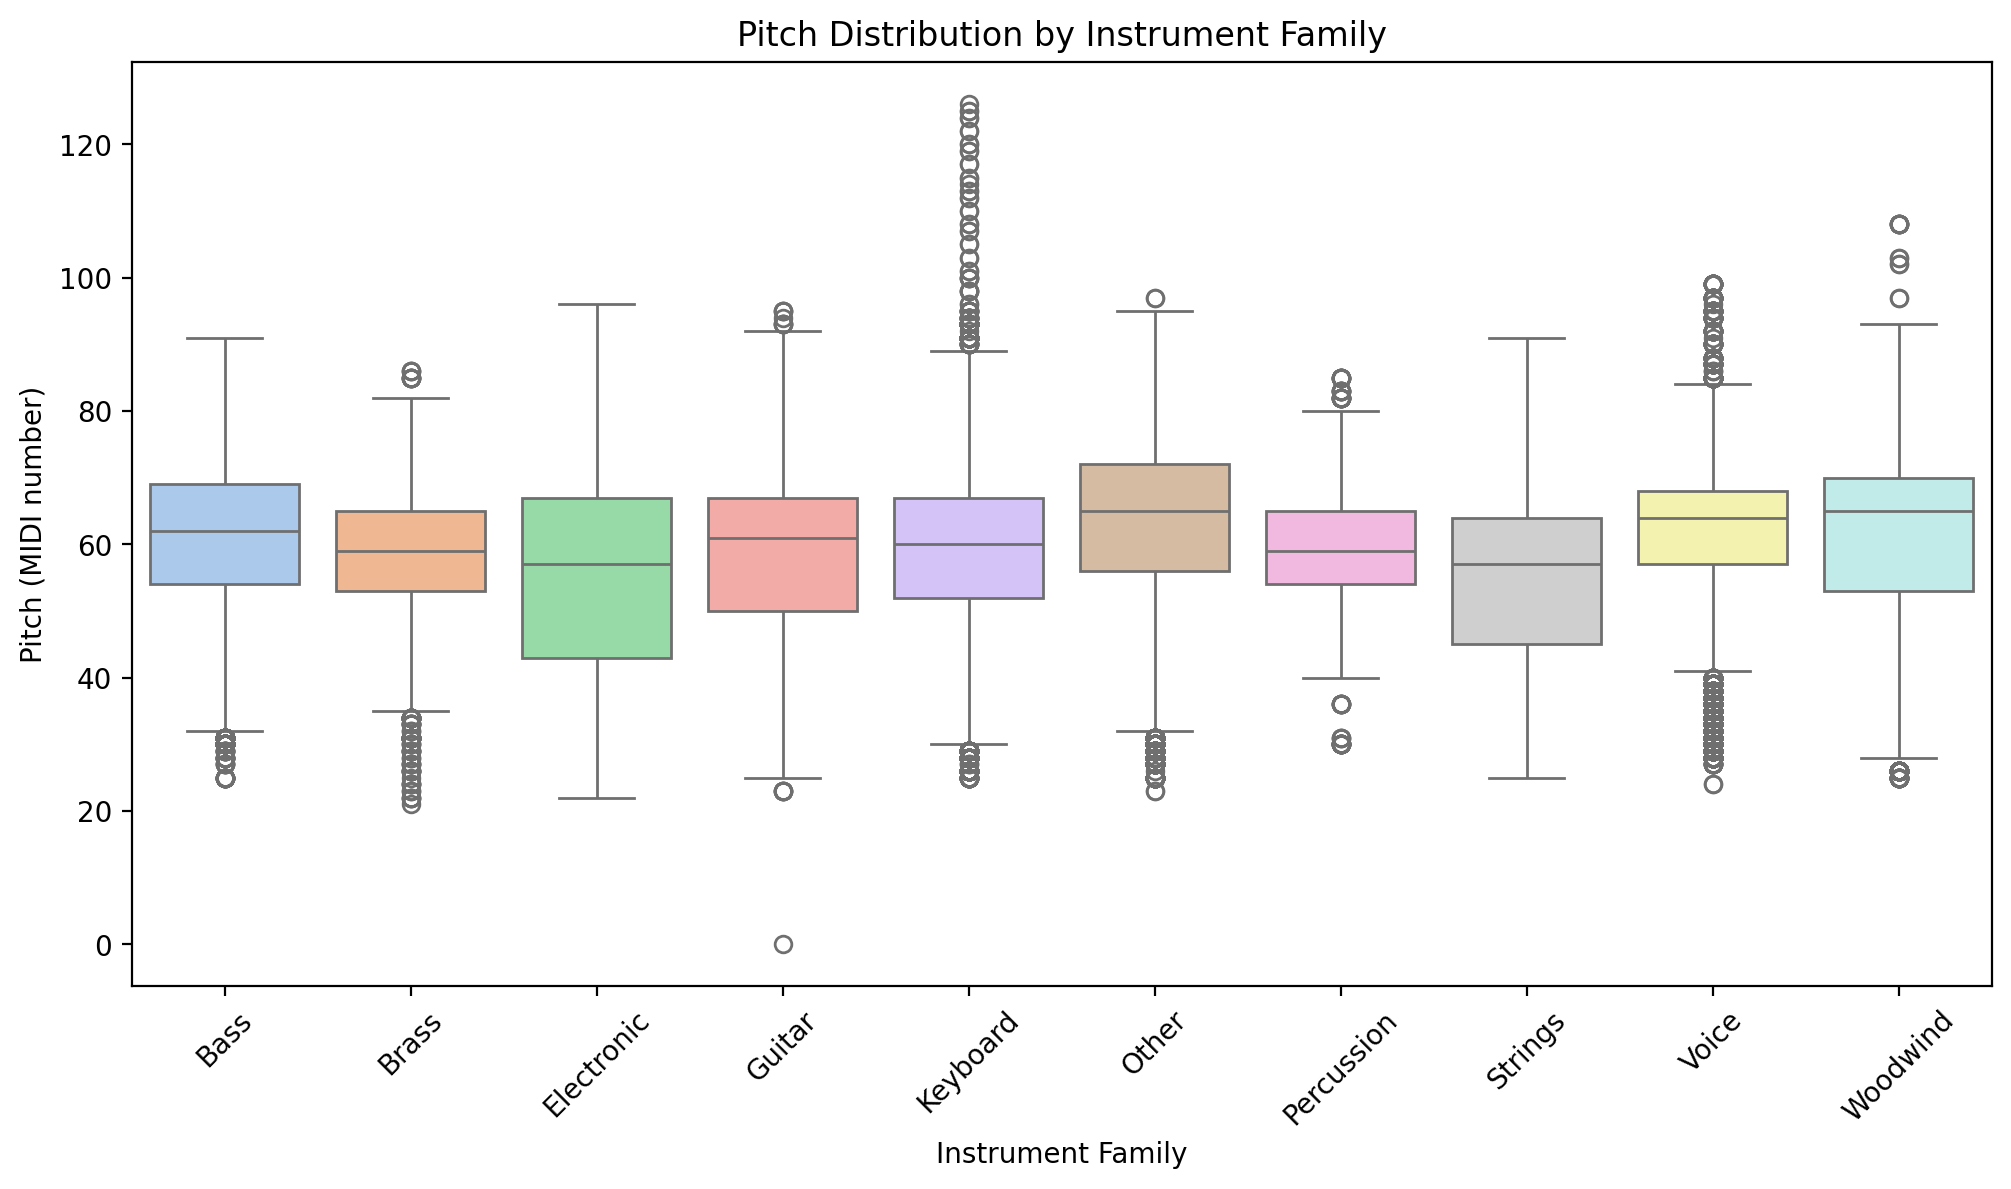

In [65]:
families = sorted(df['instrument_family'].unique())

# Filter and plot pitch distribution by instrument family
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df,
    x='instrument_family',
    y='pitch',
    palette='pastel',
    order=families
)
plt.title('Pitch Distribution by Instrument Family')
plt.xlabel('Instrument Family')
plt.ylabel('Pitch (MIDI number)')
plt.xticks(rotation=45)
plt.show()

In [60]:
# --- Descriptive statistics pitch by genre ---
print("Pitch statistics by Genre:")
df.groupby('genre')['pitch'].describe()

Pitch statistics by Genre:


,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
alternative_rock,7460.0,47.935925,14.294451,25.0,37.00,45.0,57.0,103.0
blues,22575.0,57.600310,11.940315,25.0,53.00,60.0,66.0,85.0
classical,15371.0,63.324117,12.199964,28.0,55.00,64.0,72.0,97.0
country,14654.0,57.090078,12.765766,25.0,46.00,58.0,65.0,93.0
dance,6910.0,57.097106,10.847326,27.0,49.00,61.0,66.0,85.0
disco,9845.0,58.839309,13.724416,23.0,55.00,61.0,67.0,126.0
heavy_metal,6189.0,60.020359,17.110923,29.0,45.00,58.0,76.0,93.0
jazz,13486.0,58.305205,11.495235,21.0,52.00,60.0,67.0,94.0
new_age,21791.0,58.611583,12.672781,0.0,51.00,59.0,66.0,95.0


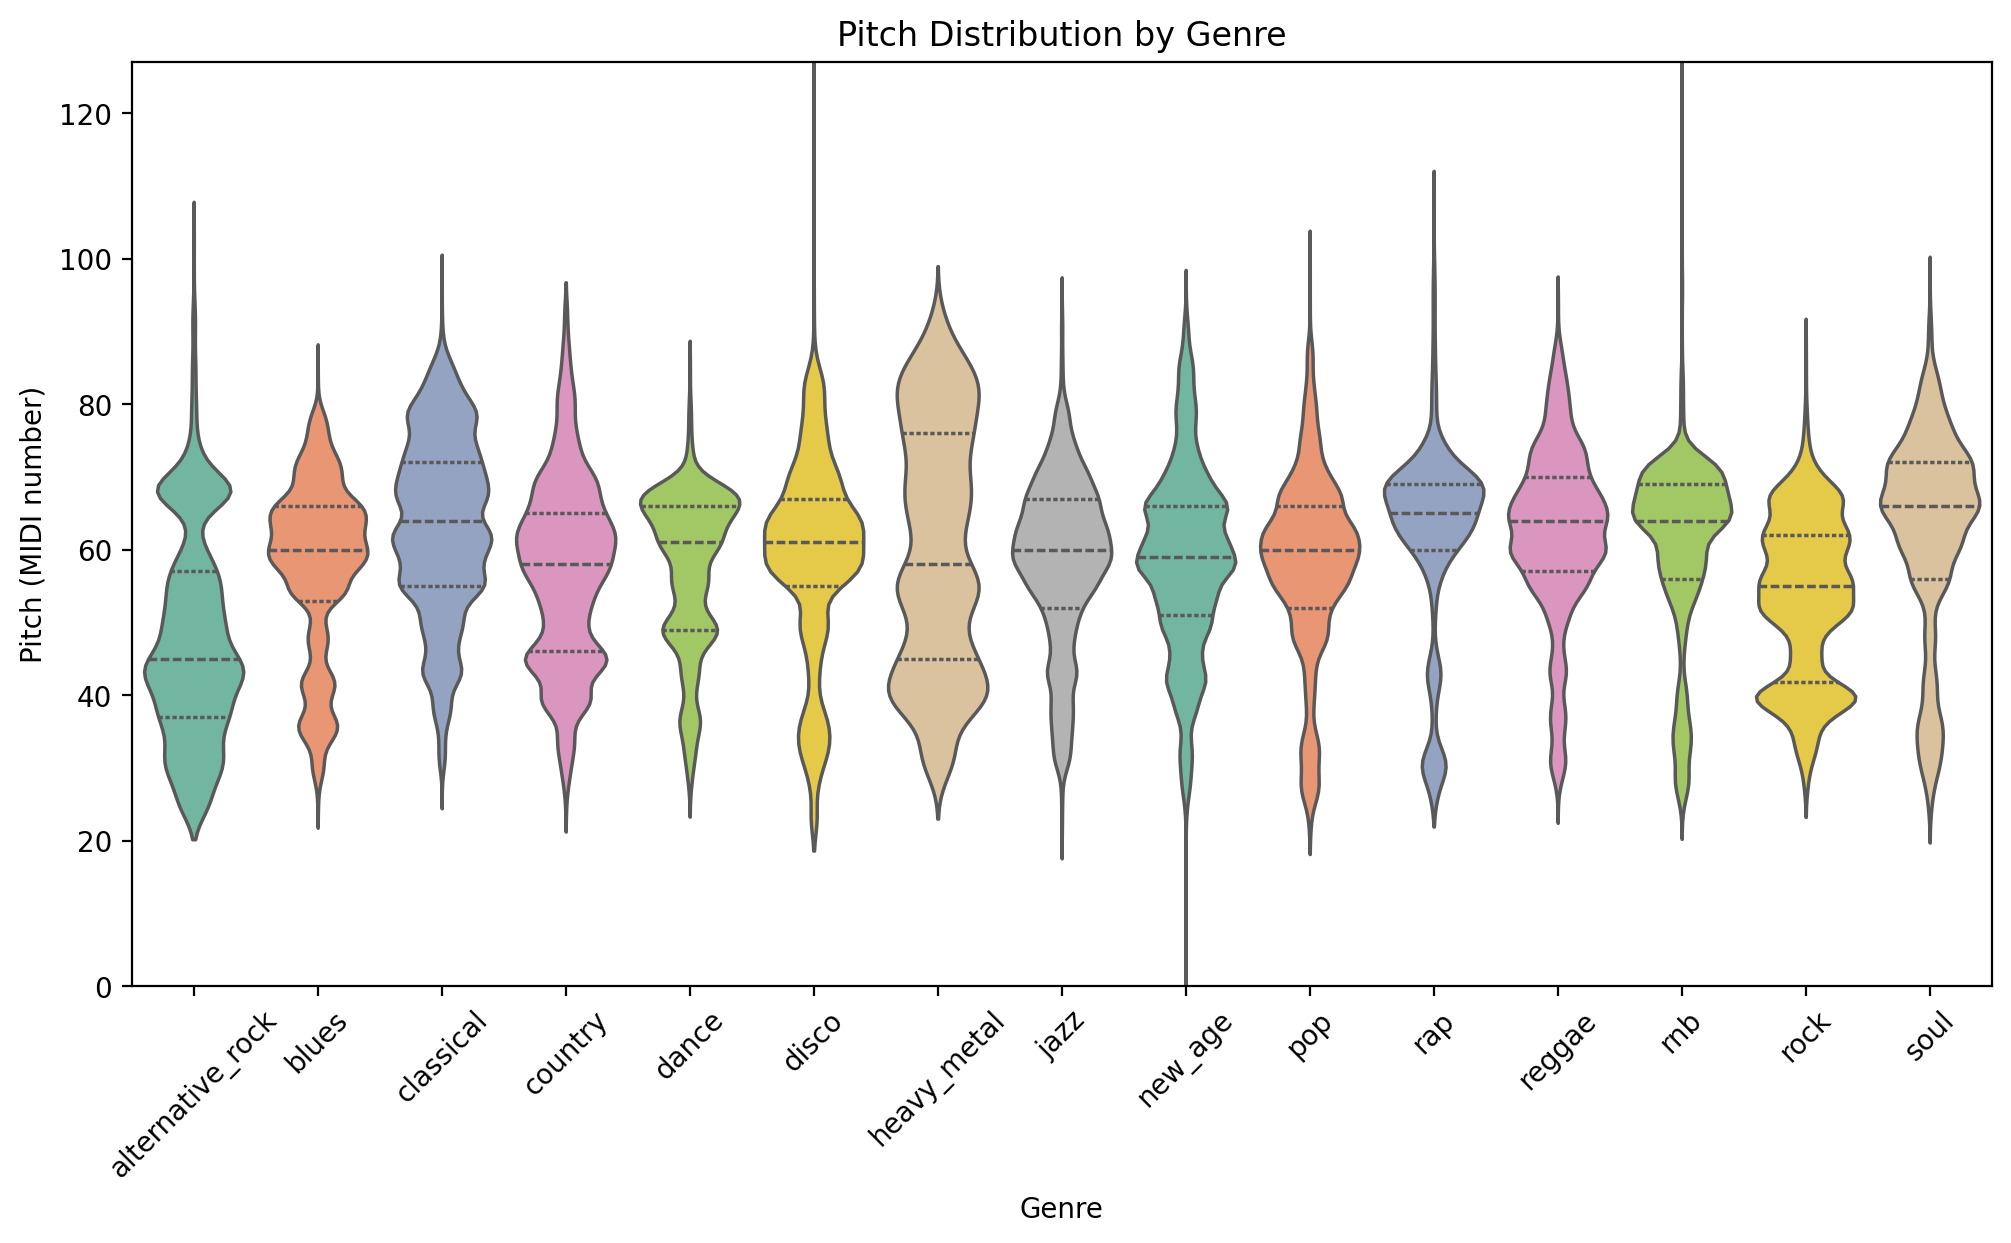

In [66]:
genres_sorted = sorted(df['genre'].unique())
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='genre', y='pitch', inner='quartile', palette='Set2', order=genres_sorted)
plt.title('Pitch Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Pitch (MIDI number)')
plt.xticks(rotation=45)
plt.ylim(0, 127)
plt.show()